# Blood Cells Cancer Segmentation and Classification
From the publicly available dataset (https://www.kaggle.com/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class).

In [26]:
import os
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers, Sequential

In [27]:
dataset_path = 'Blood cell Cancer [ALL]'
sample_images = []
sample_labels = []

def get_sample_images(dataset):
    
    # Get 4 sample images of each class
    for cls in sorted(os.listdir(dataset)):
        cls_path = os.path.join(dataset_path, cls)
        for img in os.listdir(cls_path)[:4]:
            img_path = os.path.join(dataset_path, cls, img)
            sample_images.append(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
            sample_labels.append(cls)

def plot_sample_images(images, labels):
    # Make it a 4x4 plot representation
    cols = 4
    rows = 4
    fig = plt.figure(figsize=(15, 12))

    for idx, img in enumerate(images):
        fig.add_subplot(rows, cols, idx+1)
        plt.imshow(img)
        plt.title(labels[idx])

In [28]:
get_sample_images(dataset_path)

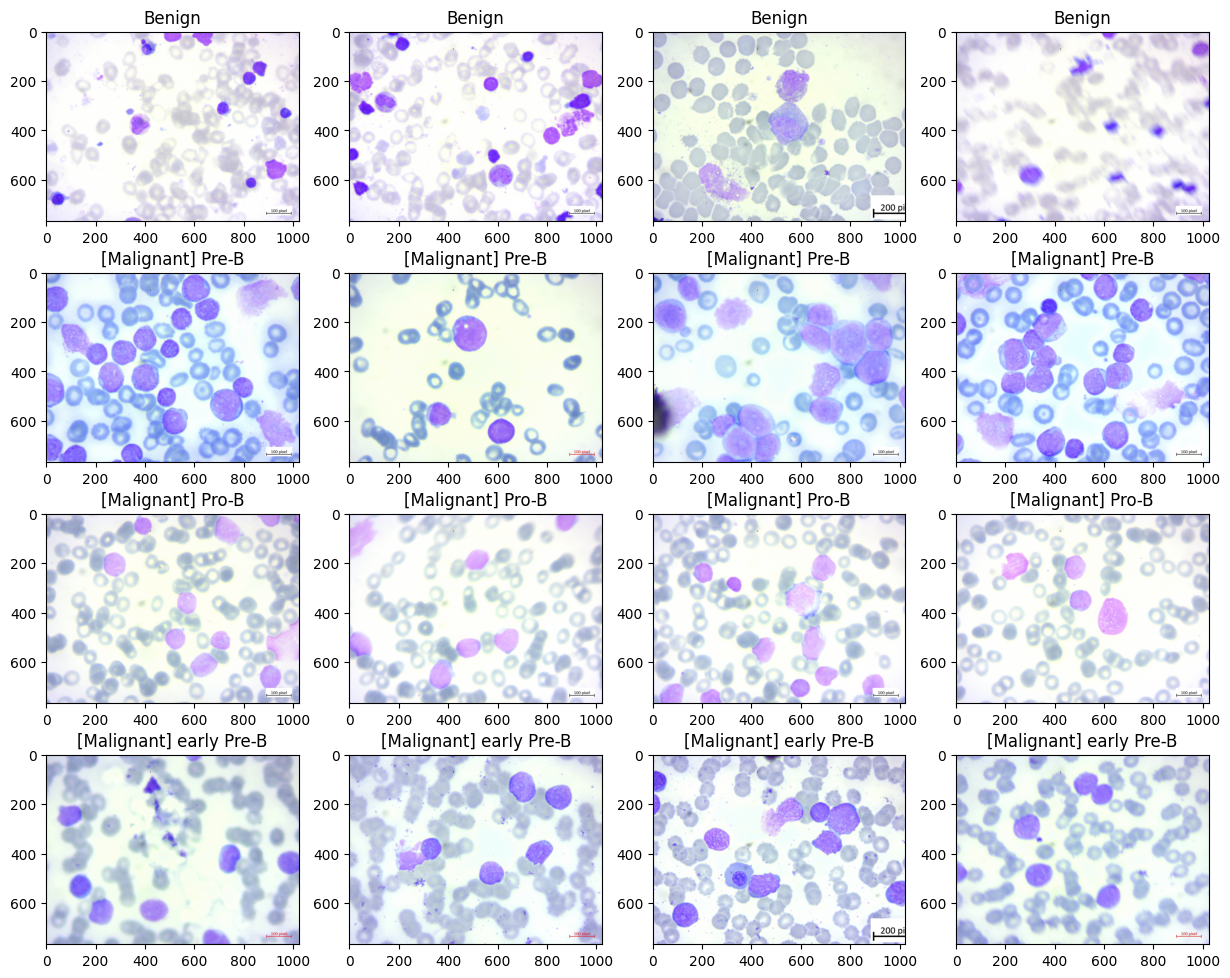

In [29]:
plot_sample_images(sample_images, sample_labels)

In [30]:
# Segment the bloodcells by HSV
def segment_bloodcells(images, labels):
    # Make it a 4x4 plot representation
    cols = 4
    rows = 4
    fig = plt.figure(figsize=(15, 12))

    # Mask lower upper bounds
    lower_purple = np.array([120, 50, 50])
    higher_purple = np.array([150, 255, 255])

    for idx, img in enumerate(images):
        fig.add_subplot(rows, cols, idx+1)

        img_rgb2hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        mask = cv2.inRange(img_rgb2hsv, lower_purple, higher_purple)
        result = cv2.bitwise_and(img, img, mask=mask)

        plt.imshow(result)
        plt.title(labels[idx])

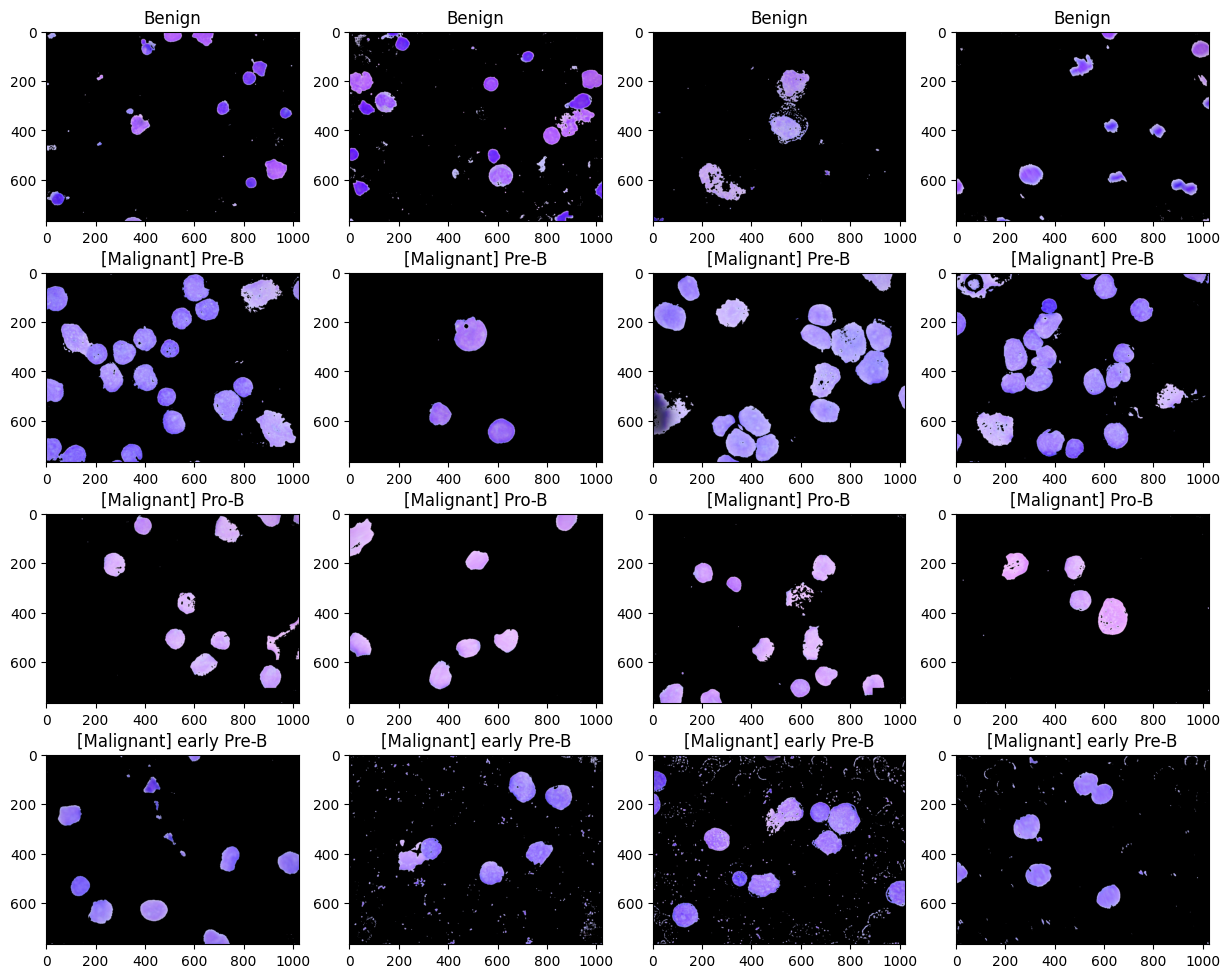

In [31]:
segment_bloodcells(sample_images, sample_labels)

### From here on out instead of just using 4 sample images from each class, i will segment around 200 of the available images of each class. This is to test if the model will perform accurately or not based on more available segmentations

In [32]:
# Redeclare sample images and labels since we're setting it back to an empty list
sample_images = []
sample_labels = []

def get_more_images(dataset):
    for cls in sorted(os.listdir(dataset)):
        cls_path = os.path.join(dataset_path, cls)

        # 200 samples
        for img in os.listdir(cls_path)[:200]:
            img_path = os.path.join(dataset_path, cls, img)
            sample_images.append(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
            sample_labels.append(cls)

In [33]:
get_more_images(dataset_path)

In [34]:
def segment_and_plot_contours(
        filtered_contours, 
        img, 
        labels, 
        idx, 
        img_copy, 
        plotted_images, 
        results_imgs, 
        results_labels, 
        plot_counts, 
        num_plots
    ):

    if filtered_contours:
        for cnt in filtered_contours:
            x, y, w, h = cv2.boundingRect(cnt)

            # Store segmented blood cells
            results_imgs.append(img[y:y+h, x:x+w])
            results_labels.append(labels[idx])

            # Draw bounding box in visualization (hence why its img_copy instead if img)
            cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 3)

        # Only plot if the class has < 4 images and total plots < num_plots
        if plot_counts[labels[idx]] < 4 and plotted_images < num_plots:
            plt.subplot(4, 4, plotted_images + 1)  # 4x4 grid
            plt.imshow(img_copy)
            plt.title(labels[idx])

            # Update counts
            plot_counts[labels[idx]] += 1
            plotted_images += 1  

    return plotted_images

def preprocess_bloodcells(images, labels):
    lower_purple = np.array([120, 50, 50])
    higher_purple = np.array([150, 255, 255])
    min_area = 1000

    results_imgs = []
    results_labels = []
    plotted_images = 0  
    num_plots = 16  # 4x4 grid
    plot_counts = defaultdict(int)  # Track plotted images per class

    fig = plt.figure(figsize=(15, 12))

    for idx, img in enumerate(images):

        img_copy = img.copy()
        img_hsv = cv2.cvtColor(img_copy, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(img_hsv, lower_purple, higher_purple)
        contours, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        # Contour filtering based on minimum contour area
        filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

        plotted_images = segment_and_plot_contours(
            filtered_contours, img, labels, idx, img_copy,
            plotted_images, results_imgs, results_labels, plot_counts, num_plots
        )

    return results_imgs, results_labels

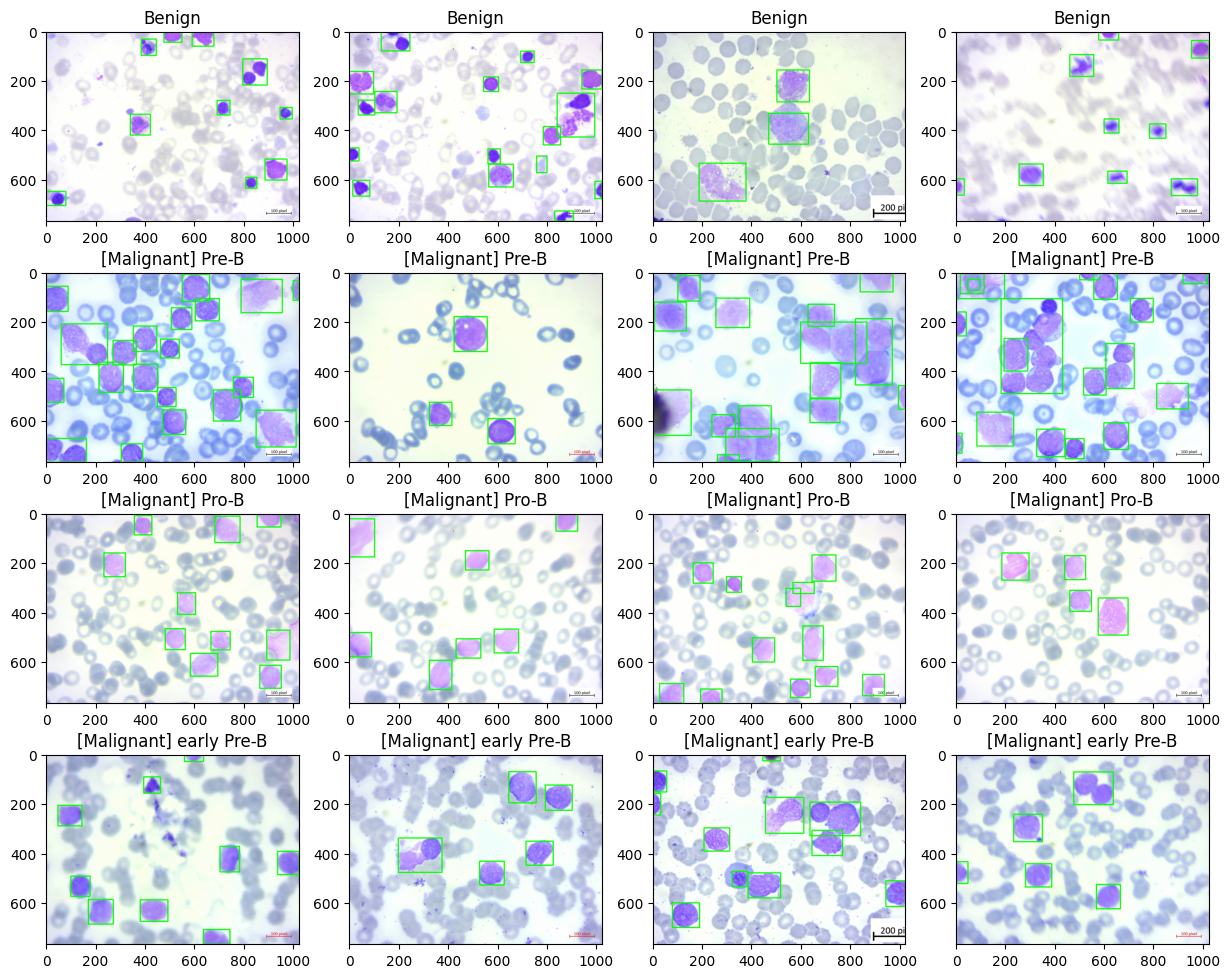

In [35]:
results_imgs, results_labels = preprocess_bloodcells(sample_images, sample_labels)

In [36]:
# Get and Plot the length of each classes after segmentation
def count_segmentation_results(labels):
    counter = defaultdict(int)
    for label in labels:
        counter[label] += 1
    return counter

def plot_segmentation_results(labels):
    plt.figure(figsize=(8,4))
    for key, value in labels.items():
        plt.bar(key, value)


In [37]:
labels_counter = count_segmentation_results(results_labels)

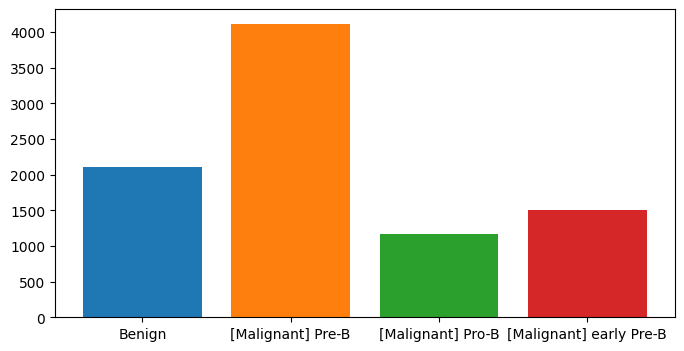

In [38]:
plot_segmentation_results(labels_counter)

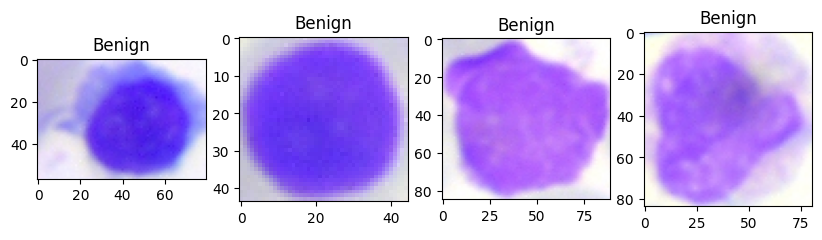

In [39]:
# Plot 4 examples of segmentation results_imgs
fig = plt.figure(figsize=(10,10))
for idx, img in enumerate(results_imgs):
    fig.add_subplot(2, 4, idx+1)
    plt.imshow(results_imgs[idx])
    plt.title(results_labels[idx])
    if idx == 3:
        break

In [40]:
# Resize all images to 224 x 224 for CNN purpouses
def resize_img(images):
    output = []
    for img in images:
        output.append(cv2.resize(img, dsize=(224,224)))
    return output

In [41]:
resized_imgs = resize_img(results_imgs)

In [42]:
# Apply one hot encoding to the target variable since we're using categorical crossentropy later
le = LabelEncoder()
results_labels = le.fit_transform(results_labels)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(resized_imgs, results_labels, test_size=0.2, random_state=42)

In [44]:
# Change into numpy array for training

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [45]:
# Image params
img_height = 224
img_width = 224
img_channel = 3
num_classes = 4

# Neural Network Layers
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, img_channel)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

/home/adhy/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,644 (98.36 MB)

 Trainable params: 25,784,644 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10)
)

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 177s 988ms/step - accuracy: 0.4531 - loss: 1.3524 - val_accuracy: 0.5586 - val_loss: 1.0355
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 177s 994ms/step - accuracy: 0.6907 - loss: 0.8226 - val_accuracy: 0.6112 - val_loss: 0.9089
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 175s 985ms/step - accuracy: 0.7399 - loss: 0.6996 - val_accuracy: 0.7221 - val_loss: 0.7755
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 174s 980ms/step - accuracy: 0.7467 - loss: 0.6707 - val_accuracy: 0.6765 - val_loss: 0.7775
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 174s 979ms/step - accuracy: 0.7587 - loss: 0.6311 - val_accuracy: 0.7340 - val_loss: 0.6899
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 175s 981ms/step - accuracy: 0.7917 - loss: 0.5660 - val_accuracy: 0.7572 - val_loss: 0.6605
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 175s 983ms/step - accuracy: 0.7803 - loss: 0.5537 - val_accuracy: 0.7333 - val_loss: 0.6618
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 174s 975ms/step - accuracy: 

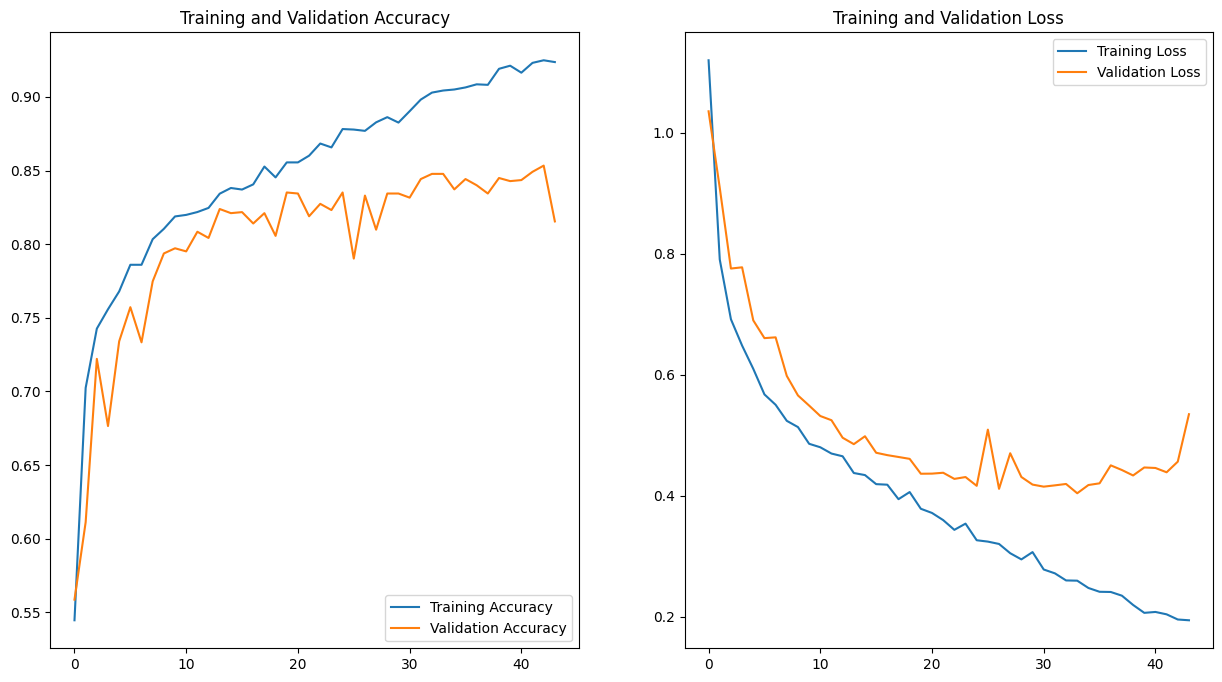

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, acc, label='Training Accuracy')
plt.plot(history.epoch, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, loss, label='Training Loss')
plt.plot(history.epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [49]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Model Accuracy: {(acc * 100):.2f}")

Model Accuracy: 83.49


In [50]:
model.save_weights('./Output/model.weights.h5')